In [1]:
from savenifti import convert_2d_image_to_nifti
from polygon import convert_polygons_to_annotations, get_tissue_union_from_mask
from filepath import convert_path, GenerateJson
import os
from wholeslidedata.annotation.wholeslideannotation import WholeSlideAnnotation
from wholeslidedata.image.wholeslideimage import WholeSlideImage
#from wholeslidedata.accessories.asap.parser import AsapAnnotationParser
from matplotlib import pyplot as plt
from wholeslidedata.samplers.patchlabelsampler import SegmentationPatchLabelSampler
from shapely.geometry import Point
import numpy as np
import pandas as pd
import SimpleITK as sitk
from wholeslidedata.annotation.utils import cv2_polygonize
from shapely import geometry
from wholeslidedata.labels import Label
from wholeslidedata.annotation.structures import Annotation
import yaml
import random
current_os = "w" if os.name == "nt" else "l"
other_os = "l" if current_os == "w" else "w"
camelyon_path = convert_path('/data/pathology/projects/pathology-mrifuse/yaml/data_camelyon17.yaml', current_os)
with open(camelyon_path, 'r') as f:
    yaml = yaml.safe_load(f)
root = yaml['path']['root']
camelyon = yaml['path']['camelyon17']     
train_data = yaml['data']['training']
labels={'Background':0,
        'Benign': 1, 
        'Tumor': 2}

current_os = "w" if os.name == "nt" else "l"
other_os = "l" if current_os == "w" else "w"
nnUNet_base = r"root_base"
nnUNet_data_root = convert_path(os.path.join(nnUNet_base, "nnUNet_raw_data"), current_os)
sorted(os.listdir(nnUNet_data_root))
nnUNet_base_linux = convert_path(nnUNet_base, to=current_os)
print("nnUNet ROOT:\t", nnUNet_base_linux)
from shapely.geometry import Point, Polygon
patch_size = (1024,1024)
#sample every 100 pixel
sample_rate = patch_size[0]*patch_size[1]
plot = False
contrast_value = 20000 #remove white patch--- masks are bad quality
save = True
# 'rst', 'umcu','rumc', 'lpon','cwz'
center_list = ['rst', 'umcu','rumc', 'lpon','cwz']
cancer_list = [ 'negative','itc', 'micro','macro']
# counts_wsi = np.zeros(n_labels)

nnUNet ROOT:	 B:\projects\pathology-mrifuse


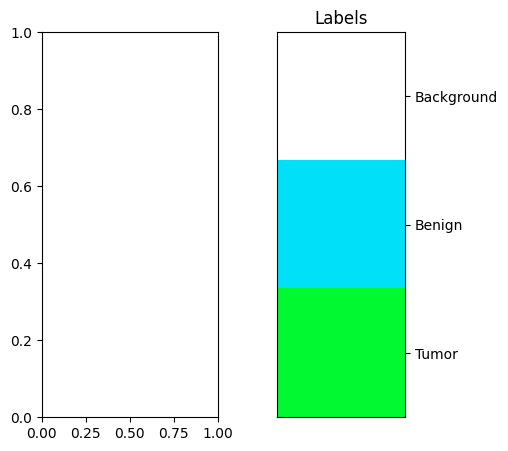

In [1]:
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm
# import pylab as plt

colormap = [ [ 0, 0, 0, 0 ], [ 0, 224, 249, 255 ], [ 0, 249, 50, 255 ], [ 174, 249, 0, 255 ], [ 249, 100, 0, 255 ], [ 249, 0, 125, 255 ], [ 149, 0, 249, 255 ], [ 0, 0, 206, 255 ], [ 0, 185, 206, 255 ], [ 0, 206, 41, 255 ], [ 143, 206, 0, 255 ], [ 206, 82, 0, 255 ], [ 206, 0, 103, 255 ], [ 124, 0, 206, 255 ], [ 0, 0, 162, 255 ], [ 0, 145, 162, 255 ], [ 0, 162, 32, 255 ], [ 114, 162, 0, 255 ], [ 162, 65, 0, 255 ], [ 162, 0, 81, 255 ], [ 97, 0, 162, 255 ], [ 0, 0, 119, 255 ], [ 0, 107, 119, 255 ], [ 0, 119, 23, 255 ], [ 83, 119, 0, 255 ], [ 119, 47, 0, 255 ], [ 119, 0, 59, 255 ], [ 71, 0, 119, 255 ], [ 100, 100, 249, 255 ], [ 100, 234, 249, 255 ], [ 100, 249, 129, 255 ], [ 204, 249, 100, 255 ], [ 249, 159, 100, 255 ], [ 249, 100, 174, 255 ], [ 189, 100, 249, 255 ], [ 82, 82, 206, 255 ], [ 82, 193, 206, 255 ], [ 82, 206, 107, 255 ], [ 168, 206, 82, 255 ], [ 206, 131, 82, 255 ], [ 206, 82, 143, 255 ], [ 156, 82, 206, 255 ], [ 65, 65, 162, 255 ], [ 65, 152, 162, 255 ], [ 65, 162, 84, 255 ], [ 132, 162, 65, 255 ], [ 162, 104, 65, 255 ], [ 162, 65, 114, 255 ], [ 123, 65, 162, 255 ], [ 47, 47, 119, 255 ], [ 47, 112, 119, 255 ], [ 47, 119, 61, 255 ], [ 97, 119, 47, 255 ], [ 119, 76, 47, 255 ], [ 119, 47, 83, 255 ], [ 90, 47, 119, 255 ], [ 174, 174, 249, 255 ], [ 174, 242, 249, 255 ], [ 174, 249, 189, 255 ], [ 227, 249, 174, 255 ], [ 249, 204, 174, 255 ], [ 249, 174, 212, 255 ], [ 219, 174, 249, 255 ], [ 143, 143, 206, 255 ], [ 143, 199, 206, 255 ], [ 143, 206, 156, 255 ], [ 187, 206, 143, 255 ], [ 206, 168, 143, 255 ], [ 206, 143, 175, 255 ], [ 181, 143, 206, 255 ], [ 114, 114, 162, 255 ], [ 114, 157, 162, 255 ], [ 114, 162, 123, 255 ], [ 147, 162, 114, 255 ], [ 162, 132, 114, 255 ], [ 162, 114, 137, 255 ], [ 142, 114, 162, 255 ], [ 83, 83, 119, 255 ], [ 83, 115, 119, 255 ], [ 83, 119, 90, 255 ], [ 108, 119, 83, 255 ], [ 119, 97, 83, 255 ], [ 119, 83, 101, 255 ], [ 104, 83, 119, 255 ], [ 224, 224, 249, 255 ], [ 224, 247, 249, 255 ], [ 224, 249, 229, 255 ], [ 242, 249, 224, 255 ], [ 249, 234, 224, 255 ], [ 249, 224, 237, 255 ], [ 239, 224, 249, 255 ], [ 185, 185, 206, 255 ], [ 185, 204, 206, 255 ], [ 185, 206, 189, 255 ], [ 199, 206, 185, 255 ], [ 206, 193, 185, 255 ], [ 206, 185, 195, 255 ], [ 197, 185, 206, 255 ], [ 145, 145, 162, 255 ], [ 145, 160, 162, 255 ], [ 145, 162, 149, 255 ], [ 157, 162, 145, 255 ], [ 162, 152, 145, 255 ], [ 162, 145, 153, 255 ], [ 155, 145, 162, 255 ], [ 107, 107, 119, 255 ], [ 107, 118, 119, 255 ], [ 107, 119, 109, 255 ], [ 115, 119, 107, 255 ], [ 119, 112, 107, 255 ], [ 119, 107, 113, 255 ], [ 114, 107, 119, 255 ], [ 0, 0, 249, 255 ], [ 0, 224, 249, 255 ], [ 0, 249, 50, 255 ], [ 174, 249, 0, 255 ], [ 249, 100, 0, 255 ], [ 249, 0, 125, 255 ], [ 149, 0, 249, 255 ], [ 0, 0, 206, 255 ], [ 0, 185, 206, 255 ], [ 0, 206, 41, 255 ], [ 143, 206, 0, 255 ], [ 206, 82, 0, 255 ], [ 206, 0, 103, 255 ], [ 124, 0, 206, 255 ], [ 0, 0, 162, 255 ], [ 0, 145, 162, 255 ], [ 0, 162, 32, 255 ], [ 114, 162, 0, 255 ], [ 162, 65, 0, 255 ], [ 162, 0, 81, 255 ], [ 97, 0, 162, 255 ], [ 0, 0, 119, 255 ], [ 0, 107, 119, 255 ], [ 0, 119, 23, 255 ], [ 83, 119, 0, 255 ], [ 119, 47, 0, 255 ], [ 119, 0, 59, 255 ], [ 71, 0, 119, 255 ], [ 100, 100, 249, 255 ], [ 100, 234, 249, 255 ], [ 100, 249, 129, 255 ], [ 204, 249, 100, 255 ], [ 249, 159, 100, 255 ], [ 249, 100, 174, 255 ], [ 189, 100, 249, 255 ], [ 82, 82, 206, 255 ], [ 82, 193, 206, 255 ], [ 82, 206, 107, 255 ], [ 168, 206, 82, 255 ], [ 206, 131, 82, 255 ], [ 206, 82, 143, 255 ], [ 156, 82, 206, 255 ], [ 65, 65, 162, 255 ], [ 65, 152, 162, 255 ], [ 65, 162, 84, 255 ], [ 132, 162, 65, 255 ], [ 162, 104, 65, 255 ], [ 162, 65, 114, 255 ], [ 123, 65, 162, 255 ], [ 47, 47, 119, 255 ], [ 47, 112, 119, 255 ], [ 47, 119, 61, 255 ], [ 97, 119, 47, 255 ], [ 119, 76, 47, 255 ], [ 119, 47, 83, 255 ], [ 90, 47, 119, 255 ], [ 174, 174, 249, 255 ], [ 174, 242, 249, 255 ], [ 174, 249, 189, 255 ], [ 227, 249, 174, 255 ], [ 249, 204, 174, 255 ], [ 249, 174, 212, 255 ], [ 219, 174, 249, 255 ], [ 143, 143, 206, 255 ], [ 143, 199, 206, 255 ], [ 143, 206, 156, 255 ], [ 187, 206, 143, 255 ], [ 206, 168, 143, 255 ], [ 206, 143, 175, 255 ], [ 181, 143, 206, 255 ], [ 114, 114, 162, 255 ], [ 114, 157, 162, 255 ], [ 114, 162, 123, 255 ], [ 147, 162, 114, 255 ], [ 162, 132, 114, 255 ], [ 162, 114, 137, 255 ], [ 142, 114, 162, 255 ], [ 83, 83, 119, 255 ], [ 83, 115, 119, 255 ], [ 83, 119, 90, 255 ], [ 108, 119, 83, 255 ], [ 119, 97, 83, 255 ], [ 119, 83, 101, 255 ], [ 104, 83, 119, 255 ], [ 224, 224, 249, 255 ], [ 224, 247, 249, 255 ], [ 224, 249, 229, 255 ], [ 242, 249, 224, 255 ], [ 249, 234, 224, 255 ], [ 249, 224, 237, 255 ], [ 239, 224, 249, 255 ], [ 185, 185, 206, 255 ], [ 185, 204, 206, 255 ], [ 185, 206, 189, 255 ], [ 199, 206, 185, 255 ], [ 206, 193, 185, 255 ], [ 206, 185, 195, 255 ], [ 197, 185, 206, 255 ], [ 145, 145, 162, 255 ], [ 145, 160, 162, 255 ], [ 145, 162, 149, 255 ], [ 157, 162, 145, 255 ], [ 162, 152, 145, 255 ], [ 162, 145, 153, 255 ], [ 155, 145, 162, 255 ], [ 107, 107, 119, 255 ], [ 107, 118, 119, 255 ], [ 107, 119, 109, 255 ], [ 115, 119, 107, 255 ], [ 119, 112, 107, 255 ], [ 119, 107, 113, 255 ], [ 114, 107, 119, 255 ], [ 0, 0, 249, 255 ], [ 0, 224, 249, 255 ], [ 0, 249, 50, 255 ], [ 174, 249, 0, 255 ], [ 249, 100, 0, 255 ], [ 249, 0, 125, 255 ], [ 149, 0, 249, 255 ], [ 0, 0, 206, 255 ], [ 0, 185, 206, 255 ], [ 0, 206, 41, 255 ], [ 143, 206, 0, 255 ], [ 206, 82, 0, 255 ], [ 206, 0, 103, 255 ], [ 124, 0, 206, 255 ], [ 0, 0, 162, 255 ], [ 0, 145, 162, 255 ], [ 0, 162, 32, 255 ], [ 114, 162, 0, 255 ], [ 162, 65, 0, 255 ], [ 162, 0, 81, 255 ], [ 97, 0, 162, 255 ], [ 0, 0, 119, 255 ], [ 0, 107, 119, 255 ], [ 0, 119, 23, 255 ], [ 83, 119, 0, 255 ], [ 119, 47, 0, 255 ], [ 119, 0, 59, 255 ], [ 71, 0, 119, 255 ], [ 100, 100, 249, 255 ], [ 100, 234, 249, 255 ], [ 100, 249, 129, 255 ], [ 0, 249, 50, 255 ] ]
colormap = np.array(colormap)/255.
cmap = LinearSegmentedColormap.from_list('my_cmap', colors=colormap)

label_names = ['Background','Benign','Tumor']
label_index = list(range(len(label_names)))
n_labels = len(label_names)
label_plot_args = {"cmap":cmap, "vmin":0, "vmax":255, "interpolation":"none"}



In [2]:
import pandas as pd
trainer = 'nnUNetTrainerV2_BN__nnUNet_RGB_scaleTo_0_1_bs8_ps512_TEST2'
# Specify the path to the CSV file
patchsize = 1024
plots = 2
spacing = 1
df_total = []

for center in ['umcu','rumc',  'cwz','lpon','rst' ]:

    csv_file_path = convert_path(rf'/{center}.csv',to = current_os )
    df = pd.read_csv(csv_file_path)
        
    df_total.append(df)

In [4]:
df_total = pd.concat(df_total)
dict_data = df_total.to_dict(orient='records')
sorted_data = sorted(dict_data, key=lambda x: 100*x['max_uncertain']+x['uncertainty_score'], reverse= True)


In [ ]:

task_name = f'Task0{i}_name_{sample_per_slide}'
task_root = os.path.join(nnUNet_data_root, task_name)
task_root = convert_path(task_root, current_os)
print("TASK:\t\t", task_name)
nnUNet_base_linux = convert_path(nnUNet_base, to=current_os)
print("nnUNet ROOT:\t", nnUNet_base_linux)
image_folder = os.path.join(task_root, "imagesTr")
image_folder = convert_path(image_folder, current_os)
label_folder = os.path.join(task_root, "labelsTr")
label_folder = convert_path(label_folder, current_os)
if not(os.path.isdir(image_folder)):
    os.makedirs(image_folder)
if not(os.path.isdir(label_folder)):
    os.makedirs(label_folder)

sample_num = sample_per_slide*15*5
for i,sample in enumerate(range(sample_num)):
    if sample> len(sorted_data):
        sample = random.randint(0,len(sorted_data))
    data = sorted_data[sample]
    filename = data['filename'][:-16]
    x = random.randint(data['x']-2*patch_size[0]/2,data['x']+2*patch_size[0]/2)
    y = random.randint(data['y']-2*patch_size[0]/2,data['y']+2*patch_size[0]/2)
    image = convert_path(f'CAMELYON17\images\{filename}.tif',  to=current_os)
    mask = convert_path(f'CAMELYON17\masks\{filename}_mask.tif',  to=current_os)
    s = os.path.split(image)[-1].split(".")[-2]

    wsi = WholeSlideImage(image, backend="asap")
    wsi_mask = WholeSlideImage(mask, backend="asap")

    image_patch = wsi.get_patch(x,y, patch_size[0], patch_size[1],  spacing,relative=True)
    mask_patch = wsi_mask.get_patch(x,y, patch_size[0], patch_size[1], spacing, relative=True)
    output_filename = filename+ '_{}'.format(i)
    if save:
        convert_2d_image_to_nifti(image_patch, os.path.join(image_folder, output_filename))
        convert_2d_image_to_nifti(mask_patch, os.path.join(label_folder, output_filename), is_seg=True)  


TASK:		 Task034_camelyon_with_uncertainty_130
nnUNet ROOT:	 /data/pathology/projects/pathology-mrifuse
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251

In [3]:
for i,sample_per_slide in zip([task_name],[sample_per_slide]):
    task_name = f'Task{i}_camelyon_uncertainty_{sample_per_slide}'
    task_root = os.path.join(nnUNet_data_root, task_name)
    task_root = convert_path(task_root, current_os)
    print("TASK:\t\t", task_name)
    nnUNet_base_linux = convert_path(nnUNet_base, to=current_os)
    print("nnUNet ROOT:\t", nnUNet_base_linux)
    image_folder = os.path.join(task_root, "imagesTr")
    image_folder = convert_path(image_folder, current_os)
    label_folder = os.path.join(task_root, "labelsTr")
    label_folder = convert_path(label_folder, current_os)
    os.makedirs(image_folder, exist_ok=True)
    os.makedirs(label_folder, exist_ok=True)
    dataset_path = task_root
    GenerateJson(dataset_path)

TASK:		 Task100_camelyon_uncertainty_100
nnUNet ROOT:	 B:\projects\pathology-mrifuse
